<a href="https://colab.research.google.com/github/nataliarufino/braintumor_CNN/blob/main/Practical_Task_DNN_1_1_Brain_Tumor_CNN_(Nat%C3%A1lia_Rufino).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this task, we should

*   Load the Brain Tumor MRI Dataset;

  Link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

*   Categorize the images into classes: glioma, meningioma, no-tumor, pituitary
*   Implement a convolutional neural network architecture to perform model training using the Sequential class;
*   Implement the ModelCheckpoint callback method;
*   Display accuracy and loss graphs during training and validation steps;
*   Provide accuracy and confusion matrix.

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np

Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Prepare the Data

Unzip the file

In [ ]:
!unzip /content/drive/MyDrive/Datasets/brain.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: brain/Training/glioma/Tr-gl_0715.jpg  
  inflating: brain/Training/glioma/Tr-gl_0716.jpg  
  inflating: brain/Training/glioma/Tr-gl_0717.jpg  
  inflating: brain/Training/glioma/Tr-gl_0718.jpg  
  inflating: brain/Training/glioma/Tr-gl_0719.jpg  
  inflating: brain/Training/glioma/Tr-gl_0720.jpg  
  inflating: brain/Training/glioma/Tr-gl_0721.jpg  
  inflating: brain/Training/glioma/Tr-gl_0722.jpg  
  inflating: brain/Training/glioma/Tr-gl_0723.jpg  
  inflating: brain/Training/glioma/Tr-gl_0724.jpg  
  inflating: brain/Training/glioma/Tr-gl_0725.jpg  
  inflating: brain/Training/glioma/Tr-gl_0726.jpg  
  inflating: brain/Training/glioma/Tr-gl_0727.jpg  
  inflating: brain/Training/glioma/Tr-gl_0728.jpg  
  inflating: brain/Training/glioma/Tr-gl_0729.jpg  
  inflating: brain/Training/glioma/Tr-gl_0730.jpg  
  inflating: brain/Training/glioma/Tr-gl_0731.jpg  
  inflating: brain/Training/glioma/Tr-gl_0732.jpg  
  inf

## Defining each parameter

`batch_size`: Batch size indicates how many images the neural network will analyze before updating its weights.

A larger batch size can accelerate training but requires more memory.

`img_height` and `img_width`: Dimensions to which input images will be resized before being fed into the neural network.

`rescale`: Default value of 1/255 transforms pixel values from the range of 0-255 to the range of 0-1.

Use `tf.keras.preprocessing.image.ImageDatagenerator()` to load the data.

In [ ]:
batch_size = 64
img_height = 170
img_width = 170
rescale = 1/255
data_dir = '/content/brain'

# splitting the data, 20% for validation and 80% for training
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=rescale,
                                                          validation_split=0.2)
# subset for training
train_ds = datagen.flow_from_directory(
    directory = data_dir + '/Training',
    target_size = (img_height, img_width),
    class_mode = 'categorical',
    color_mode = 'grayscale',
    classes = ['glioma','meningioma','notumor','pituitary'],
    seed = 123,
    batch_size = batch_size,
    subset = 'training')

# subset for validation
valid_ds = datagen.flow_from_directory(
    directory = data_dir + '/Training',
    target_size = (img_height, img_width),
    class_mode = 'categorical',
    color_mode = 'grayscale',
    classes = ['glioma','meningioma','notumor','pituitary'],
    seed = 123,
    batch_size = batch_size,
    subset = 'validation')

# test folder, without subset as the network will test all images
test_ds = datagen.flow_from_directory(
    directory = data_dir + '/Testing',
    target_size = (img_height, img_width),
    class_mode = 'categorical',
    color_mode = 'grayscale',
    classes = ['glioma','meningioma','notumor','pituitary'],
    seed = 123,
    shuffle=False,
    batch_size = batch_size)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


After splitting the data, it's important to obtain a batch of data from the training set to better understand how the images are being processed.

So we use `next(train_ds)`

In [ ]:
x_batch, y_batch = next(train_ds)

In [ ]:
x_batch.shape

(64, 170, 170, 1)

[0. 1. 0. 0.]


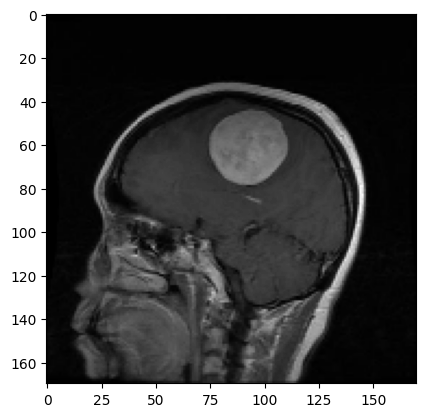

In [ ]:
# to verify the content of the images and ensure they are being loaded correctly

print(y_batch[30])
image = x_batch[30]
plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray)
plt.show()

## Build the model

To build the model, we will use the `Sequential`, class, where layers are added one after another

I chose `(kernel_size)` of (3,3) e pool `(pool_size)` (2, 2), as they are common sizes in convolutional architectures. They capture local information from the images and progressively reduce dimensions.

I will test a dense layer with 512 units.

In [ ]:
reg = 1e-5

model = Sequential([InputLayer(input_shape=(170,170,1)),
                    Conv2D(8, kernel_size=(3,3), activation='relu', activity_regularizer=l2(reg)),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(16, kernel_size=(3,3), activation='relu', activity_regularizer=l2(reg)),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(64, kernel_size=(3,3), activation='relu', activity_regularizer=l2(reg)),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(128, kernel_size=(3,3), activation='relu', activity_regularizer=l2(reg)),
                    Flatten(),
                    Dense(512, activation='relu', activity_regularizer=l2(reg)),
                    Dropout(0.5),
                    Dense(4, activation='softmax', activity_regularizer=l2(reg))])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 168, 168, 8)       80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 84, 84, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 82, 82, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 41, 41, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 39, 39, 64)        9280      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 19, 19, 64)      

Now we will use `ModelCheckpoint` callback to save the model's weights during training.

In [ ]:
callback = [tf.keras.callbacks.ModelCheckpoint('models/best_model.h5',
                                              monitor='val_accuracy',
                                              verbose=1,
                                              save_best_only=True)]

Since this is a multiclass problem,`categorical_crossentropy` is used to compile the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision()])

## Train the model

In [ ]:
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=20,
                    callbacks=callback)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.9820 - accuracy: 0.5769 - precision_2: 0.7792
Epoch 1: val_accuracy improved from -inf to 0.68186, saving model to models/best_model.h5
72/72 [==============================] - 14s 147ms/step - loss: 0.9820 - accuracy: 0.5769 - precision_2: 0.7792 - val_loss: 0.9145 - val_accuracy: 0.6819 - val_precision_2: 0.7439
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.7683 - precision_2: 0.8162
Epoch 2: val_accuracy improved from 0.68186 to 0.71604, saving model to models/best_model.h5
72/72 [==============================] - 11s 149ms/step - loss: 0.6118 - accuracy: 0.7683 - precision_2: 0.8162 - val_loss: 0.8352 - val_accuracy: 0.7160 - val_precision_2: 0.7591
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.8296 - precision_2: 0.8508
Epoch 3: val_accuracy did not improve from 0.71604
72/72 [==============================] - 10s 139ms/step - 

## Evaluate the model

We have reached the model evaluation part, which is crucial in the training and fine-tuning process.

The test dataset `test_ds` is used here to assess the model's ability to generalize to previously unseen data

In [ ]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 2s 84ms/step - loss: 0.3908 - accuracy: 0.8688 - precision_2: 0.8756


We will plot the accuracy and loss graphs to assess how the model is generalizing

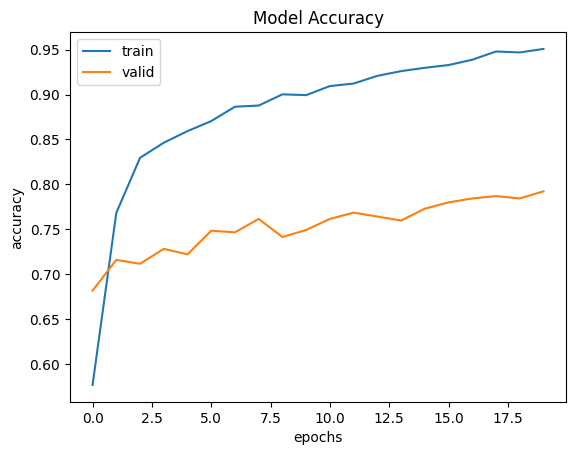

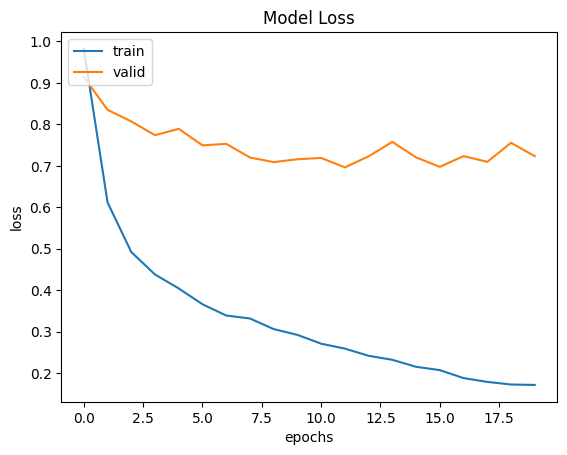

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Defining `predictions`

In [ ]:
predictions = model.predict(test_ds)
predictions

21/21 [==============================] - 2s 77ms/step


array([[1.8824437e-01, 6.7356592e-01, 4.3979123e-02, 9.4210640e-02],
       [7.0039403e-01, 1.6408402e-01, 2.1594299e-04, 1.3530599e-01],
       [9.2202586e-01, 7.7478565e-02, 9.4458250e-05, 4.0111368e-04],
       ...,
       [3.7284166e-04, 8.1493808e-03, 1.6711885e-03, 9.8980659e-01],
       [5.4292479e-03, 3.2304788e-03, 1.0468918e-03, 9.9029338e-01],
       [1.9642930e-04, 9.4127627e-03, 1.7372742e-02, 9.7301811e-01]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(predictions, 1)
y_true = test_ds.classes

print(y_pred.shape)
print(y_true.shape)

(1311,)
(1311,)


Creating the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[249  46   0   5]
 [ 16 202  63  25]
 [  3   8 393   1]
 [  0   5   0 295]]


`Seaborn` provides enhanced customization and visualization options, making it easier to interpret the distribution of predicted and actual classes, and enabling a comprehensive understanding of the model's accuracy and misclassifications.

Text(0.5, 58.7222222222222, 'Predict')

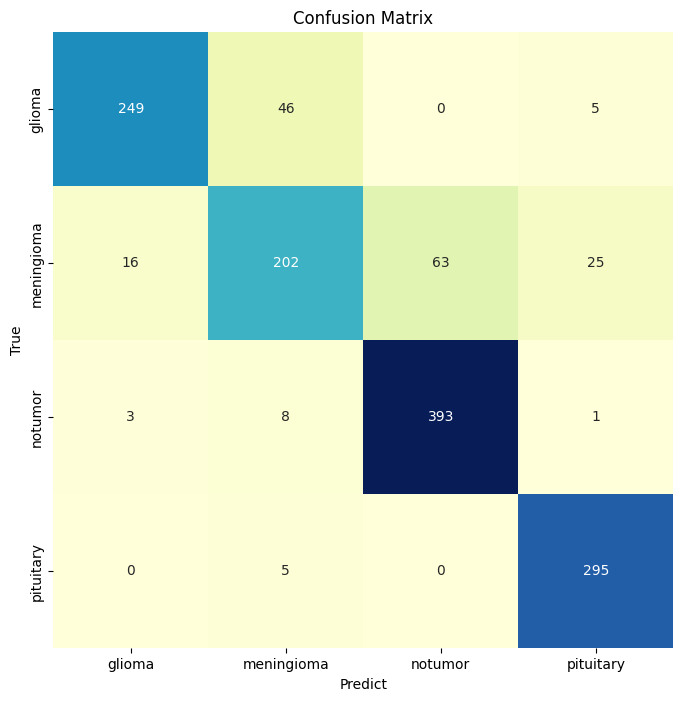

In [ ]:
import seaborn as sn

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']


plt.subplots(figsize=(8,8))
sn.heatmap(cm, cmap='YlGnBu',
           annot=True, fmt='d',
           cbar=False,
           xticklabels=labels,
           yticklabels=labels)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predict')

## Save and load the model

In [ ]:
model.save('model_save.h5')

In [ ]:
model_loaded = tf.keras.models.load_model('model_save.h5')

In [ ]:
scores = model_loaded.evaluate(test_ds)

21/21 [==============================] - 3s 116ms/step - loss: 0.3908 - accuracy: 0.8688 - precision_2: 0.8756


The validation curve in the accuracy and loss graphs shows that the validation oscillates a lot, which usually indicates that the model is having trouble generalizing. The oscillation suggests that the model is reacting sensitively to small fluctuations in the validation data, i.e. the model is starting to overfit the training data and is therefore not doing well with new data

**Some ways to increase the generalizability of your model would be:**

* Increase the Size of the Data Set: The more varied data you have, the better the model's ability to learn generalizable patterns;

* Regularization:
 Here I use L2 in the convolutional and dense layers, which is a great practice. Regularization helps to avoid overfitting by penalizing large weights. The idea to improve would be to adjust the regularization hyperparameters to find a good balance between the model's complexity and its ability to generalize.

* Reduce Network Complexity:
The complexity of the network, i.e. the number of layers and parameters, can contribute to overfitting. So decreasing the number of filters in the convolutional layers or reducing the size of the dense layers can prevent the model from memorizing the training data.